# NVAR Temporal Subsampling

In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns


In [2]:
sys.path.append("..")
from rcgfd import NVARDataset, BigPlot, SingleTimePlot, plot_ke_relerr, MetricsPlot, global_legend

In [3]:
plt.style.use("./rc-gfd.mplstyle")

In [4]:
fig_dir = "../figures"
if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)

In [5]:
nvd = NVARDataset(
    n_sub=(1,4,16),
    n_lag=(0,1,2,3),
)

In [6]:
ds = nvd()

Grab one sample for some plotting

In [7]:
xds = ds.sel(n_lag=1, n_sub=[1,4,16], sample=49)

In [8]:
#bp = BigPlot()
#fig, axs = bp(xds)
#fig.savefig(f"{fig_dir}/nvar_big_plot.jpg", dpi=300, bbox_inches="tight")

In [9]:
#bp = BigPlot(diff_t0=False)
#fig, axs = bp(xds)

## Qualitative Plots

### Smoothing vs Nsub

In [10]:
stp = SingleTimePlot(diff_t0=False, time=4*3600)

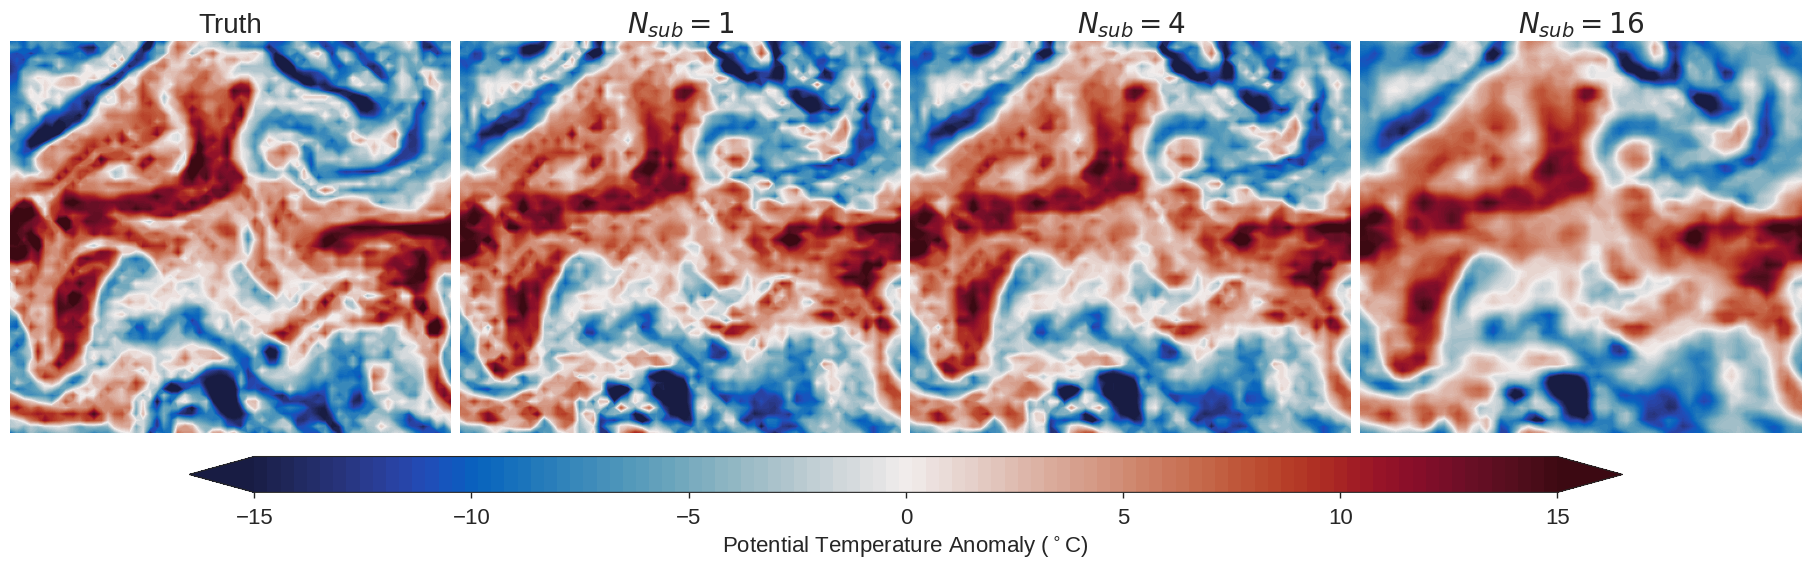

In [11]:
fig, axs = stp(xds, col_dim="n_sub")
[ax.set(title=r"$N_{sub} = %d$" % n_sub) for n_sub, ax in zip(xds.n_sub.values, axs[1:])];
fig.savefig(f"{fig_dir}/nvar_4hr_snap.jpg", bbox_inches="tight", dpi=300)

### Nature of instabilities

In [12]:
stp = SingleTimePlot(diff_t0=False,
                     time=8*3600,
                     subplot_kw={"figsize": (4,4.5), 'constrained_layout':True},
                     plot_truth=False)

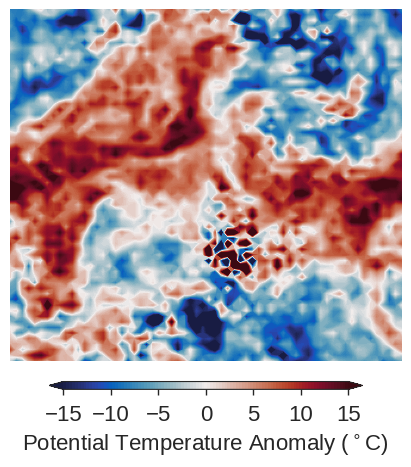

In [13]:
fig, ax = stp(ds.sel(n_lag=1,n_sub=[1],sample=49), col_dim="n_sub")
ax[0].set(title='')
fig.savefig(f"{fig_dir}/nvar_instabilities.jpg", bbox_inches="tight", dpi=300)

## Quantitative Metrics

In [14]:
ds.nrmse.load();
ds.p_nrmse.load();

In [15]:
mp = MetricsPlot(
    metrics=("nrmse", "ke_nrmse"),
    cdim="n_sub",
    show_persistence=True,
)

### Compare $N_{sub}$

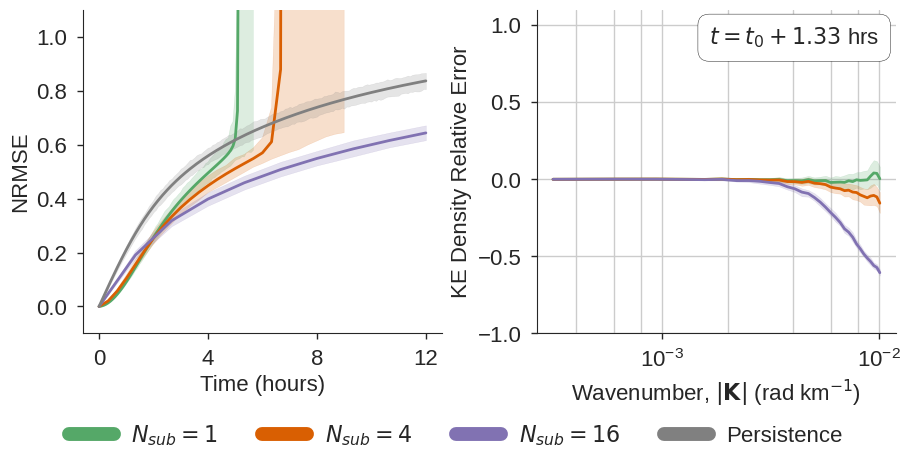

In [16]:
fig, axs = mp(ds.sel(n_lag=1), show_time=True)
axs[0].set(ylim=[-0.1, 1.1],
           xlabel="Time (hours)",
          )
axs[0].legend().remove()
axs[-1].clear()

plot_ke_relerr(
    ds["ke_rel_err"].sel(n_lag=1),
    hours=(1.33,),
    cdim="n_sub",
    fig=fig,
    axs=axs[-1],
)
labels = [mp.n_sub_label(x) for x in [1,4,16]] + ["Persistence"]
global_legend(fig, labels, color_start=mp.color_start)
fig.savefig(f"{fig_dir}/nvar-nrmse-and-kere.pdf", bbox_inches="tight")

### Effect of memory

In [17]:
mp = MetricsPlot(
    metrics=("nrmse", "nrmse", "nrmse"),
    cdim="n_lag",
    show_persistence=True,
)

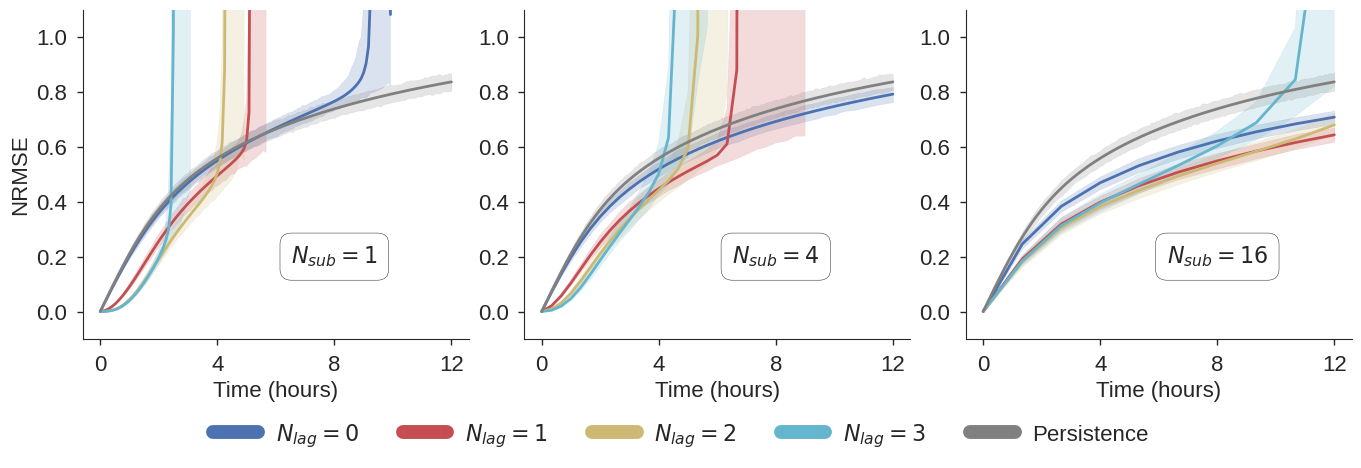

In [18]:
fig, axs = mp(ds.sel(n_sub=1), show_time=True)
[ax.clear() for ax in axs[1:]]
mp.plot_vs_time(ds.nrmse.sel(n_sub=4), ds.p_nrmse, ax=axs[1])
mp.plot_vs_time(ds.nrmse.sel(n_sub=16), ds.p_nrmse, ax=axs[2])
[ax.legend().remove() for ax in axs]
[ax.set(ylabel="") for ax in axs[1:]]

for n_sub, ax in zip(ds.n_sub.values, axs):
    ax.set(ylim=[-.1,1.1], xlabel="Time (hours)")
    ax.text(
        8*3600, 0.2,"$N_{sub} = %d$" % n_sub,
        ha="center",
        va="center",
        transform=ax.transData,
        bbox={
            "facecolor": "white",
            "edgecolor": "black",
            "boxstyle": "round,pad=.5",
        }
    )

labels = [r"$N_{lag} = %d$" % n_lag for n_lag in ds.n_lag.values] + ["Persistence"]
global_legend(fig, labels, color_start=mp.color_start)

fig.savefig(f"{fig_dir}/nvar_nrmse_vs_memory.pdf", bbox_inches="tight")

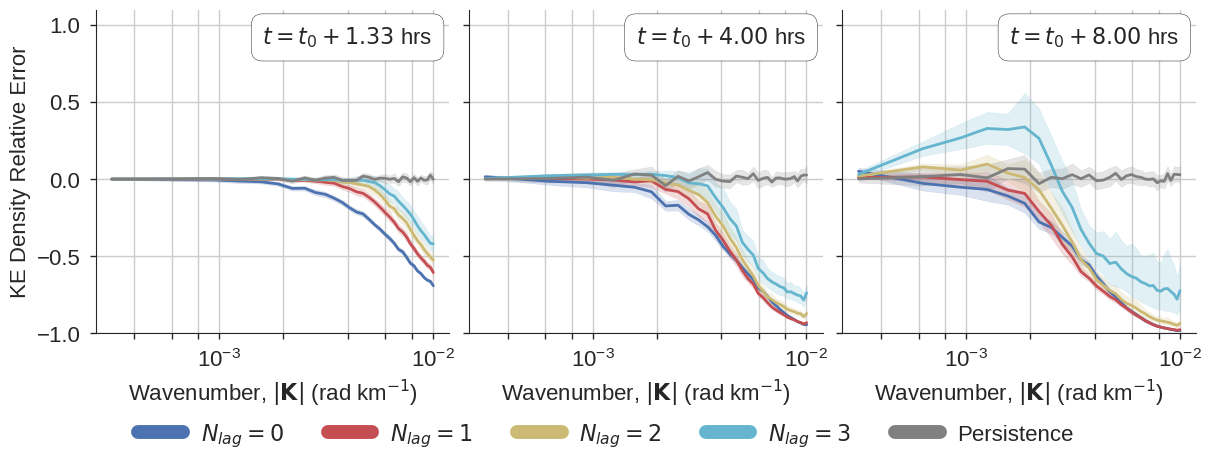

In [19]:
fig, axs = plot_ke_relerr(
    ds["ke_rel_err"].sel(n_sub=16),
    cdim="n_lag",
    clabel=lambda n_lag: r"$N_{lag} = %d$" % n_lag,
    show_persistence=True,
    persistence=ds["p_ke_rel_err"]
)
fig.get_children()[-1].remove()

labels = [r"$N_{lag} = %d$" % n_lag for n_lag in ds.n_lag.values] + ["Persistence"]
global_legend(fig, labels, color_start=mp.color_start)

fig.savefig(f"{fig_dir}/nvar_ke_relerr_vs_lag.pdf", bbox_inches="tight")

### More plots

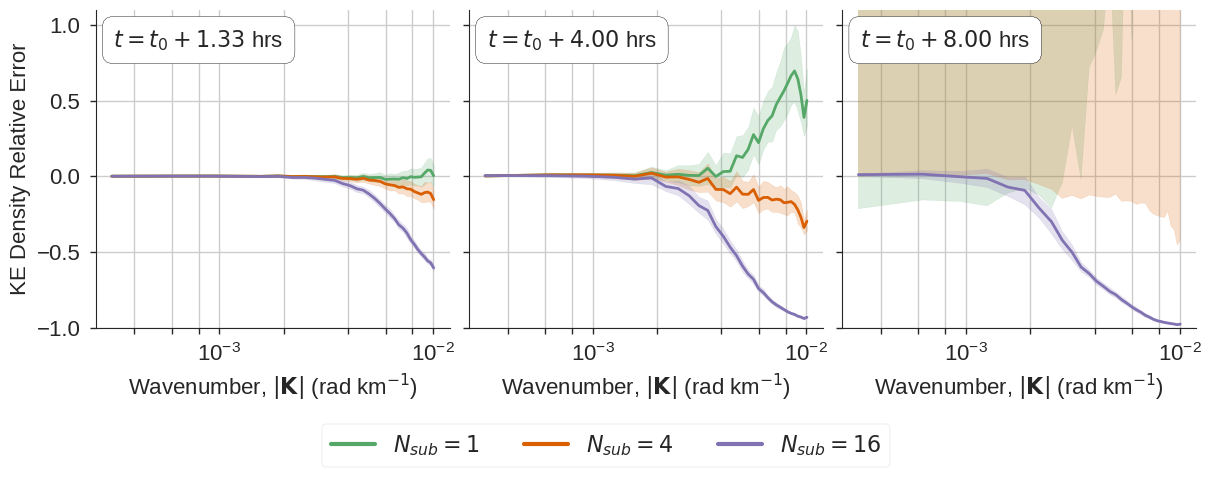

In [23]:
fig, axs = plot_ke_relerr(
    ds["ke_rel_err"].sel(n_lag=1),
    cdim="n_sub",
)